In [1]:
import tifffile
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 # this is "opencv" installed in the virtual environment "tutorial"

In [2]:
# import image (TIFF)
dir = "C:/Users/xxxx/xxxx/" # change to your directory where the data file is
file1 = "HeLa_GM130_CENP-F_011.tif" # file name
img1 = tifffile.imread(os.path.join(dir, file1))

# check the shape of imported image (should be an ndarray of 3 channnels, 1024 pixels in y, 1024 pixels in x)
img1.shape

(3, 1024, 1024)

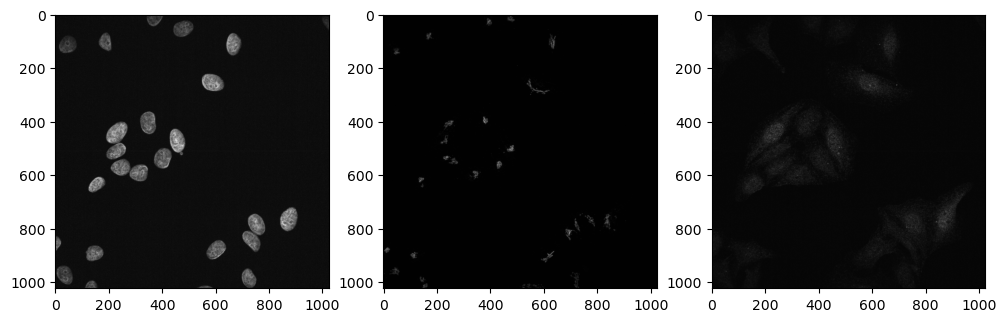

In [3]:
# show image
plt.figure(figsize=(12,6))
plt.subplot(131) # creates "1" row, "3" columns, and then put a plot in the "1st" slot (1,3,1)
plt.imshow(img1[0], cmap="gray") # image channel 0; Hoechst/DNA (shown in gray; you can play around with colormaps like "Blues" and "summer")
plt.subplot(132) # similarly, put another plot in the "2nd" slot (1,3,2)
plt.imshow(img1[1], cmap="gray") # image channel 1; GM130/Golgi (shown in gray)
plt.subplot(133)
plt.imshow(img1[2], cmap="gray") # image channel 2; CENP-F/G2 (shown in gray)
plt.show()

In [4]:
# show the max pixel value of channel 0
# 16-bit image can take pixel values above 255, up to 65535
np.max(img1[0])

839

In [5]:
# automatic thresholding by Otsu method
threshold, img1_0_bin = cv2.threshold(img1[0], 0, 1, cv2.THRESH_OTSU)

In [6]:
print(threshold) # detemined threshold value

497.0


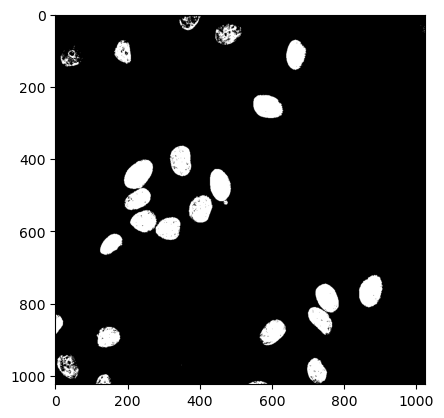

In [7]:
# show thoresholded binary image
plt.imshow(img1_0_bin, cmap="gray")
plt.show()

In [9]:
# count masks
contours, hierarchy = cv2.findContours(img1_0_bin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [133]:
len(contours) # there should be 24 nuclei but you will see more masks counted

192

In [10]:
# to remove very small fragments, blur image before thresholding
img1_0_blur = cv2.GaussianBlur(img1[0], (7,7), 7)

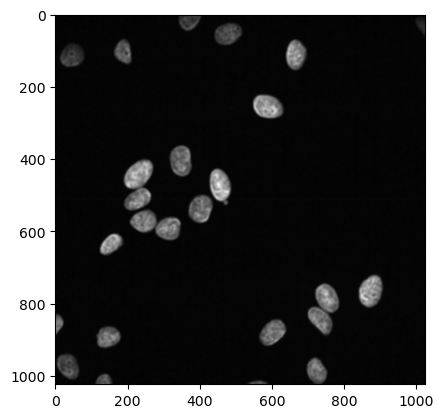

In [11]:
plt.imshow(img1_0_blur, cmap="gray")
plt.show()

In [12]:
# automatic thresholding by Otsu method
threshold, img1_0_blur_bin = cv2.threshold(img1_0_blur, 0, 1, cv2.THRESH_OTSU)

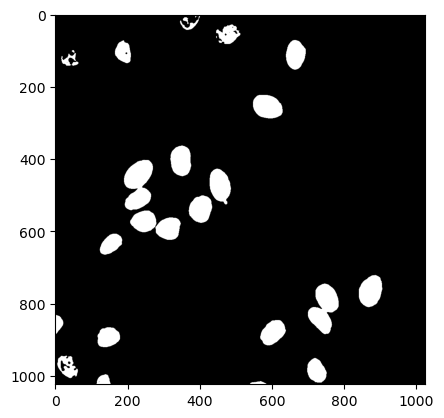

In [13]:
# outlines of masks became smoother and small fragments were removed
# some nuclei are fused and need to be segmented
plt.imshow(img1_0_blur_bin, cmap="gray")
plt.show()

In [14]:
img1_0_blur_bin.dtype # this binary image is a 16-bit image

dtype('uint16')

In [15]:
img1_0_blur_bin = np.uint8(img1_0_blur_bin) # convert to 8-bit
img1_0_blur_bin.dtype

dtype('uint8')

In [106]:
# segmentation using the watershed algorithm
# you can just run this cell and learn the details later
coefficient = 0.4 # adjust this value (0-1)

kernel = np.ones((5,5),np.uint8)
sure_bg = cv2.dilate(img1_0_blur_bin, kernel, iterations=3) # sure background
dist_transform = cv2.distanceTransform(img1_0_blur_bin, cv2.DIST_L2, 5) # distance map for sure foreground
ret, sure_fg = cv2.threshold(dist_transform, coefficient*dist_transform.max(), 255, 0) # sure foreground
sure_fg = np.uint8(sure_fg) # convert to 8-bit
unknown = cv2.subtract(sure_bg, sure_fg) # unknown region
ret, markers = cv2.connectedComponents(sure_fg) # label markers
markers = markers+1 # increment all marker labels by "1" to set the background label to "1"
markers[unknown==1] = 0 # assign "0" to unknown marker labels
img1_RGB = cv2.cvtColor(img1_0_blur_bin, cv2.COLOR_GRAY2RGB)
markers = cv2.watershed(img1_RGB, markers) # watershed
outlines = np.where(markers == -1, 255, 0)
img1_0_blur_bin2 = np.where(markers > 1, 1, 0).astype(np.uint8)

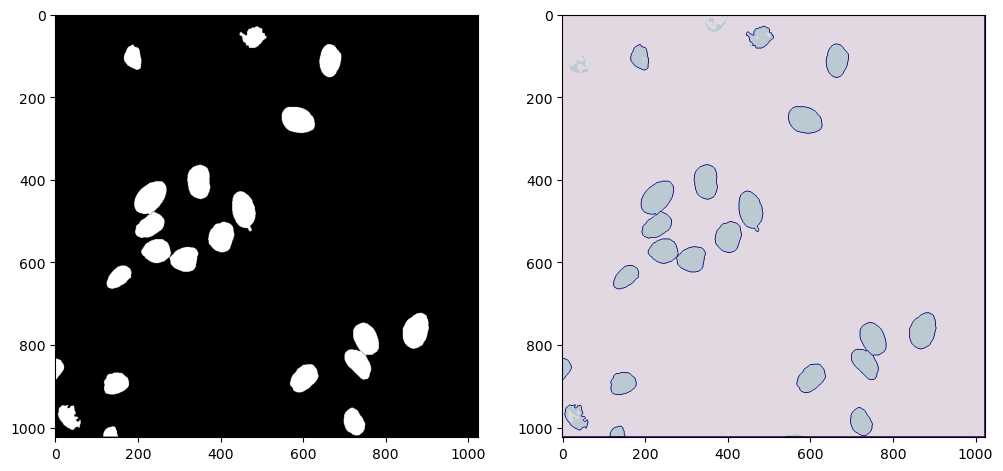

In [140]:
# show segmentation result
# good result but some nuclei are lost
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img1_0_blur_bin2, cmap="gray")
plt.subplot(122)
plt.imshow(img1_0_blur_bin*20+outlines, cmap="twilight")
plt.show()

In [175]:
# count masks; now there counted 21 of 24 nuclei
np.max(markers)-1 # subtract the background label

21

In [114]:
# apply masks to extract nuclei (ignore Golgi channel for now)
img1_masked = img1 * img1_0_blur_bin2 # you can just multiply images

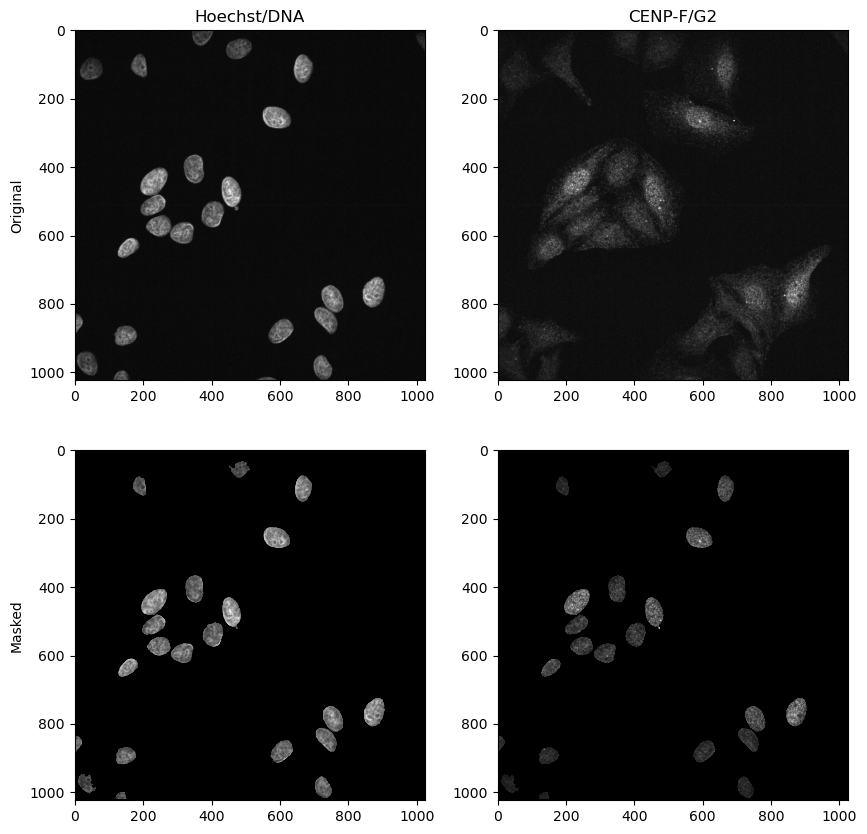

In [203]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.title("Hoechst/DNA")
plt.ylabel("Original")
plt.imshow(img1[0], cmap="gray", vmin = 400, vmax = 800)

plt.subplot(222)
plt.title("CENP-F/G2")
plt.imshow(img1[2], cmap="gray", vmin = 400, vmax = 700)

plt.subplot(223)
plt.ylabel("Masked")
plt.imshow(img1_masked[0], cmap="gray", vmin = 400, vmax = 800)

plt.subplot(224)
plt.imshow(img1_masked[2], cmap="gray", vmin = 400, vmax = 700)

plt.show()

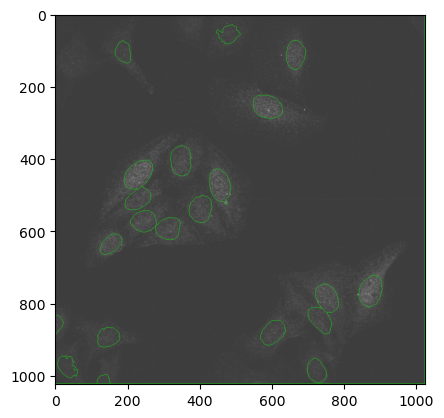

In [284]:
# merge outlines
img1_c2_clipped = np.clip(img1[2], 200, 900)
img1_c2_normalized = (img1_c2_clipped - 200)/700*200
img1_c2_normalized = img1_c2_normalized.astype("uint8")
img1_c2_outlined = np.clip(img1_c2_normalized+outlines, 0, 255)
img1_c2_RGB = cv2.cvtColor(img1_c2_outlined.astype("uint8"), cv2.COLOR_GRAY2RGB)
img1_c2_RGB_2 = np.where(img1_c2_RGB == (255,255,255), (0,255,0), img1_c2_RGB)
plt.imshow(img1_c2_RGB_2)

In [ ]:
# can you remove masks on edge?